# Diagnóstico de fallo eléctrico en motor de inducción mediante SVM
Ignacio Díaz Blanco, 2019-2023. Universidad de Oviedo

### Descripción
En este ejemplo, se utiliza un clasificador SVM (*support vector machine*) para determinar el estado de desequilibrio eléctrico de un motor de inducción. El ejemplo se puede adaptar fácilmente para analizar desequilibrios mecánicos.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat

%matplotlib inline

# Cargamos los datos, disponibles en formato Matlab (*.mat)
datos = loadmat('../../datos/dataicann.mat')

# La frecuencia de muestreo son 5000 Hz (este dato normalmente lo tienen que dar)
fm = 5000.
tm = 1/fm

# Definimos las etiquetas de las dos clases (fallo mecánico, fallo eléctrico)
# para cada uno de los 9 ensayos analizados
clase = [
    [1.,0.],
    [1.,1.],
    [0.,0.],
    [0.,1.],
    [0.,1.],
    [0.,1.],
    [0.,1.],
    [0.,1.],
    [0.,1.]
]

In [11]:
# EXTRACCIÓN DE CARACTERÍSTICAS

# Parámetros de enventanado (criterios de agrupamiento de los datos)
N = 1000     # tamaño de la ventana (esto lo elegimos nosotros)
S = 100      # definimos el "salto" entre ventana y ventana 

Fclase = []
F = []
C = []
for k in range(9):
    p = datos['z'][0][k].T
    Q = p.shape[1]
    for j in range(N,Q,S):
        for variable in [0,1,3]:
            v = p[variable,j-N:j]          # definimos la ventana actual con N elementos (p.u. respecto valor nominal)
            V = np.abs(np.fft.fft(v))             # calculamos la fft de la ventana
            f = np.arange(0,fm,fm/N)          # calculamos las frecuencias de cada armónico
            idx1 = np.where((f>20)&(f<30))     # generamos un vector de índices de los elementos que están entre ...
            idx2 = np.where((f>95)&(f<105))    # generamos un vector de índices de los elementos que están entre ...
            idx3 = np.where((f>45)&(f<55))

            C.append(np.sqrt(np.sum(2*V[idx1]**2))/N)
            C.append(np.sqrt(np.sum(2*V[idx2]**2))/N)
            C.append(np.sqrt(np.sum(2*V[idx3]**2))/N)
        F.append(C)
        Fclase.append(clase[k])
        C = []
        

# tras el bucle for, F es una lista de listas
# para poder usar funciones de numpy y matplotlib la convertimos en un array
F = np.array(F)
F = F[:,[0,1,3,4,8]];
Fclase = np.array(Fclase)

In [12]:
# CREAMOS CONJUNTOS DE ENTRENAMIENTO Y TEST (mediante partición aleatoria)

# total de datos de la matriz F
Q = F.shape[0]

# para entrenamiento utilizamos solo indices de los vectores de características usados para entrenamiento
# idxtrn = np.random.permutation(np.hstack((np.arange(500),np.arange(1000,1100))))[:200]
idxtrn = np.random.permutation(np.arange(1300))[:100]
Xtrn   = F[idxtrn,:]
ytrn   = Fclase[idxtrn,1][:,np.newaxis]

# para test utilizamos todos los datos
idxtst = np.arange(Q)
Xtst   = F[idxtst,:]
ytst   = Fclase[idxtst,1][:,np.newaxis]


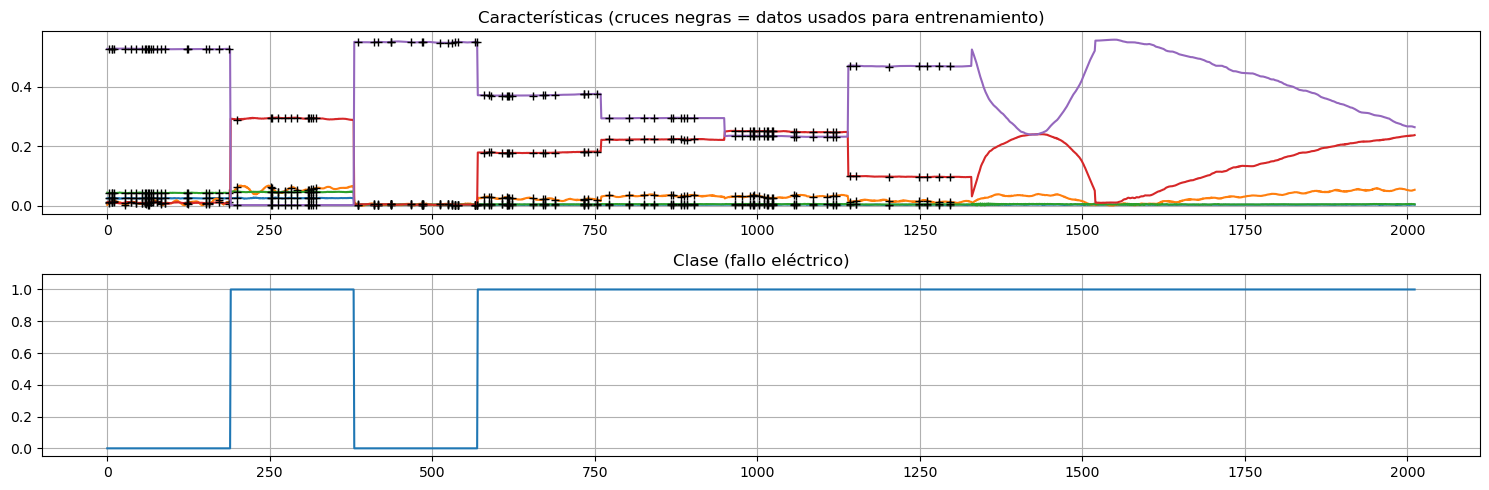

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
for k in range(5):
    plt.plot(F[:,k])
    plt.plot(idxtrn,F[idxtrn,k],'k+')
plt.title('Características (cruces negras = datos usados para entrenamiento)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(Fclase[:,1])
plt.axis(ymax=1.1)
plt.title('Clase (fallo eléctrico)')
plt.grid(True)

plt.tight_layout()

In [14]:
Fclase[idxtrn,1][:,np.newaxis].shape

(100, 1)

In [15]:
# PREDICCIÓN Support Vector Regression (SVR)
from sklearn.svm import SVR

# NORMALIZACIÓN DE LAS VARIABLES
from sklearn.preprocessing import MinMaxScaler

# Creamos una clase de normalización
minmaxx = MinMaxScaler(feature_range=(-1,1))
minmaxy = MinMaxScaler(feature_range=(0,1))

# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos)
minmaxx.fit(Xtrn)
minmaxy.fit(ytrn)


# Aplicamos la normalización a los datos de entrenamiento y a los de test
Xtrn_norm    = minmaxx.transform(Xtrn)
ytrn_norm    = minmaxy.transform(ytrn)
Xtst_norm    = minmaxx.transform(Xtst)
ytst_norm    = minmaxy.transform(ytst)

In [16]:
# CLASIFICACIÓN SVM

# este método permite calcular los coeficientes de una aproximación rbf
# mediante una optimización "robusta". No está limitado a rbf. Es extensible a otros tipos de aproximaciones.
clf = SVR(kernel='rbf', gamma=.5, C=2, epsilon=.001)

clf.fit(Xtrn_norm,ytrn_norm.ravel())
ytst_norm_est = clf.predict(Xtst_norm)

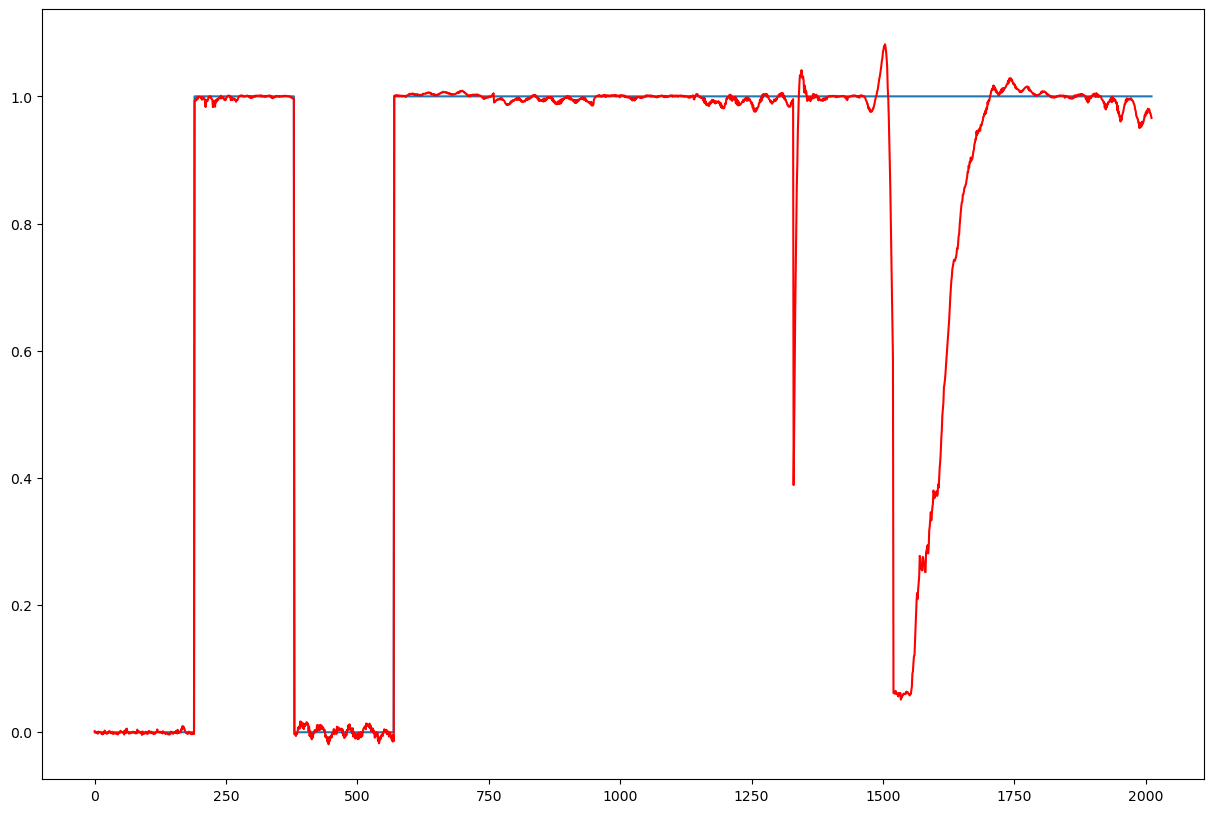

In [17]:
plt.figure(1,figsize=(15,10))
plt.plot(ytst_norm)
plt.plot(ytst_norm_est,'r')

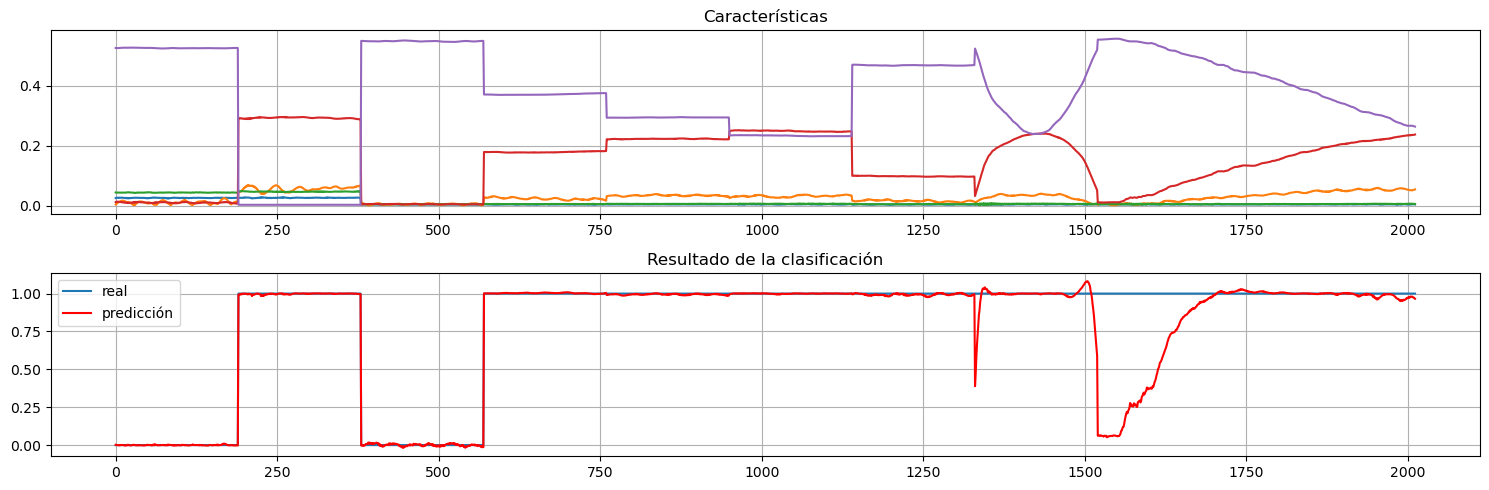

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
for k in range(5):
    plt.plot(F[:,k])
plt.title('Características')
plt.grid(True)
    
plt.subplot(2,1,2)
plt.plot(ytst_norm)
plt.plot(ytst_norm_est,'r')
plt.title('Resultado de la clasificación')
plt.legend(['real','predicción'])
plt.grid(True)

plt.tight_layout()

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">"Diagnóstico de fallo eléctrico en motor de inducción mediante SVM"</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.